>>>>    # Customer Segmentation / Clustering

In [323]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

### Loading the datasets

In [327]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [328]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [329]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


### Merging Customers and Transactions

In [332]:
data = pd.merge(transactions, customers, on='CustomerID', how='left')

# Aggregate metrics (Total Spending and Transaction Frequency)
customer_metrics = data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    transaction_frequency=('TransactionID', 'nunique'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

### Standardizing the data

In [335]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_metrics[['total_spending', 'transaction_frequency', 'avg_transaction_value']])

# PCA for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

### Function to evaluate clustering performance

In [338]:
def evaluate_clustering(model, data):
    if isinstance(model, DBSCAN):
        labels = model.fit_predict(data)
    else:
        model.fit(data)
        labels = model.labels_ if hasattr(model, 'labels_') else model.predict(data)
    
    db_index = davies_bouldin_score(data, labels)
    silhouette_avg = silhouette_score(data, labels)
    return labels, db_index, silhouette_avg

### Function to plot clusters

In [341]:
def plot_clusters(model, data, algorithm_name, pca_data=None):
    if isinstance(model, GaussianMixture):
        labels = model.predict(data)
    else:
        labels = model.labels_ if hasattr(model, 'labels_') else model.predict(data)
    
    plt.figure(figsize=(10, 8))
    
    if pca_data is not None:
        plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    else:
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
    plt.title(f'{algorithm_name} Clustering')
    plt.xlabel('PCA Component 1' if pca_data is not None else 'Feature 1')
    plt.ylabel('PCA Component 2' if pca_data is not None else 'Feature 2')
    plt.colorbar()
    plt.show()

# K-Means Clustering

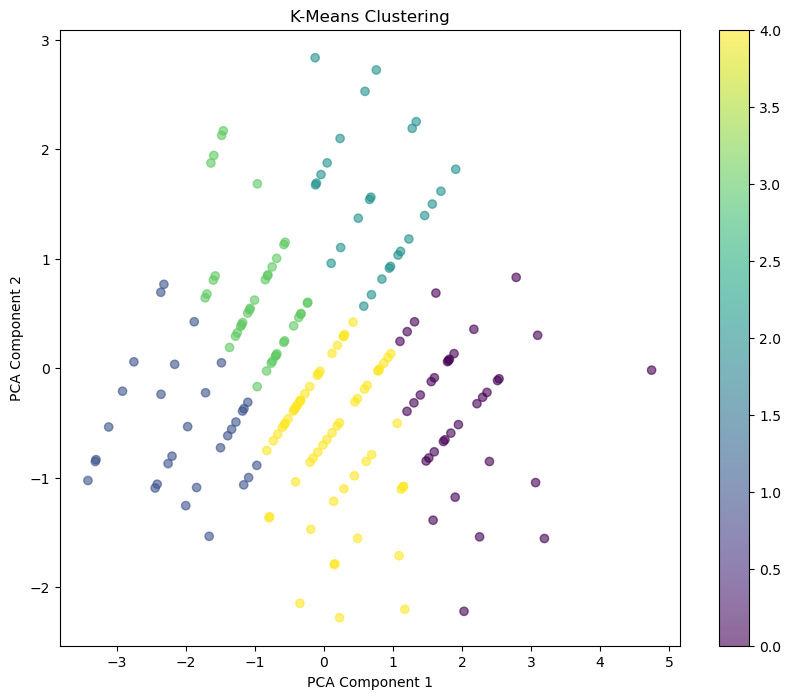

In [344]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels, kmeans_db_index, kmeans_silhouette = evaluate_clustering(kmeans, scaled_data)
plot_clusters(kmeans, scaled_data, 'K-Means', pca_data)

# DBSCAN Clustering

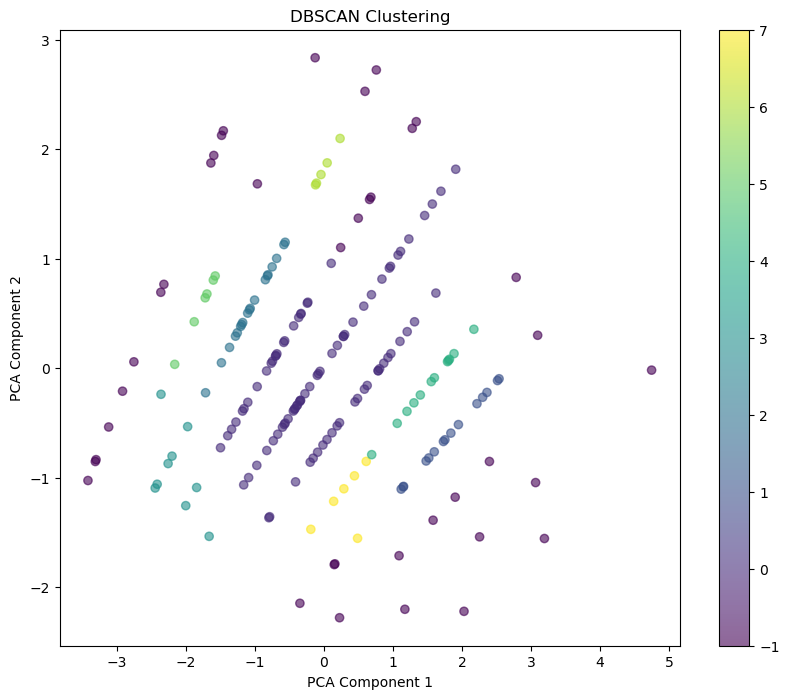

In [347]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels, dbscan_db_index, dbscan_silhouette = evaluate_clustering(dbscan, scaled_data)
plot_clusters(dbscan, scaled_data, 'DBSCAN', pca_data)

# Agglomerative Clustering

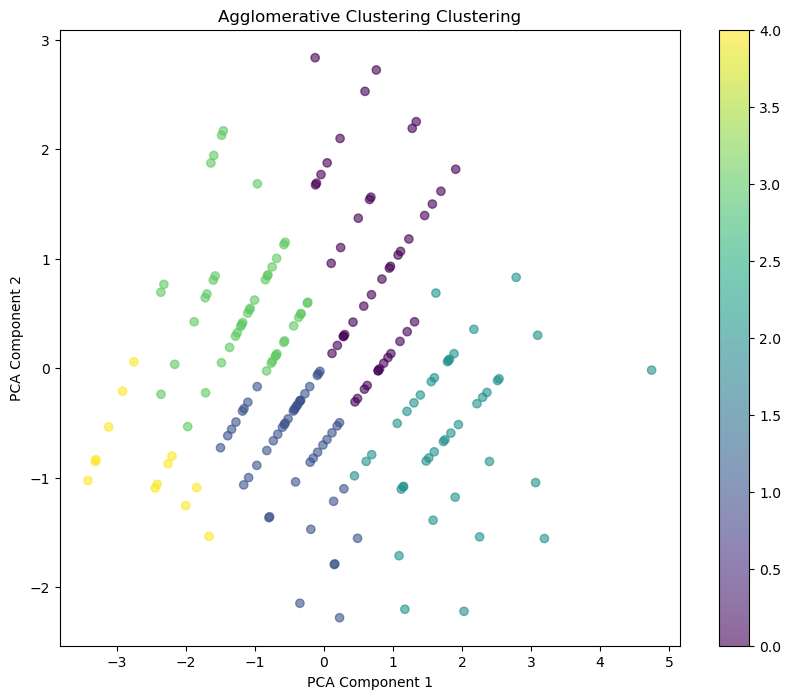

In [350]:
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_clustering_labels, agg_clustering_db_index, agg_clustering_silhouette = evaluate_clustering(agg_clustering, scaled_data)
plot_clusters(agg_clustering, scaled_data, 'Agglomerative Clustering', pca_data)

# Gaussian Mixture Model (GMM)

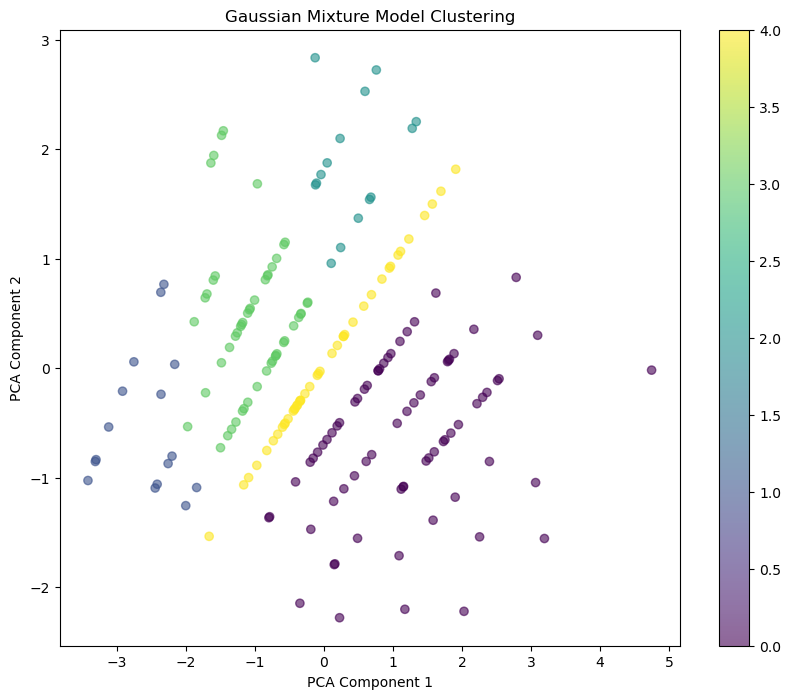

In [353]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels, gmm_db_index, gmm_silhouette = evaluate_clustering(gmm, scaled_data)
plot_clusters(gmm, scaled_data, 'Gaussian Mixture Model', pca_data)

# Clustering evaluation results

In [355]:
print(f'K-Means: DB Index = {kmeans_db_index:.4f}, Silhouette Score = {kmeans_silhouette:.4f}')
print(f'DBSCAN: DB Index = {dbscan_db_index:.4f}, Silhouette Score = {dbscan_silhouette:.4f}')
print(f'Agglomerative Clustering: DB Index = {agg_clustering_db_index:.4f}, Silhouette Score = {agg_clustering_silhouette:.4f}')
print(f'Gaussian Mixture Model: DB Index = {gmm_db_index:.4f}, Silhouette Score = {gmm_silhouette:.4f}')

K-Means: DB Index = 0.8525, Silhouette Score = 0.3535
DBSCAN: DB Index = 4.8445, Silhouette Score = -0.0552
Agglomerative Clustering: DB Index = 0.8851, Silhouette Score = 0.3427
Gaussian Mixture Model: DB Index = 1.2412, Silhouette Score = 0.2196


### Hyperparameter Tuning for K-Means using GridSearchCV

In [367]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define a function to use GridSearchCV for unsupervised clustering
def grid_search_kmeans(data):
    param_grid = {'n_clusters': range(2, 11)}  # Search for k between 2 and 10
    kmeans = KMeans(random_state=42)

    # GridSearchCV does not work directly for clustering, so we need to define a custom scorer
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        return silhouette_score(X, labels)

    grid_search = GridSearchCV(kmeans, param_grid, scoring=silhouette_scorer, cv=3)
    grid_search.fit(data)
    
    print(f"Best number of clusters (k): {grid_search.best_params_['n_clusters']}")
    print(f"Best Silhouette Score: {grid_search.best_score_}")

# Run the GridSearch for KMeans
grid_search_kmeans(scaled_data)

Best number of clusters (k): 2
Best Silhouette Score: 0.38064340686779774


### Hyperparameter Tuning for DBSCAN using GridSearchCV:

In [370]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Define a function to use GridSearchCV for DBSCAN
def grid_search_dbscan(data):
    param_grid = {
        'eps': [0.1, 0.2, 0.3, 0.4],
        'min_samples': [3, 5, 7]
    }
    dbscan = DBSCAN()

    # GridSearchCV does not work directly for clustering, so we need to define a custom scorer
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        if len(set(labels)) > 1:  # Only compute silhouette score if more than 1 cluster
            return silhouette_score(X, labels)
        else:
            return -1  # Return a negative value if only 1 cluster is found

    grid_search = GridSearchCV(dbscan, param_grid, scoring=silhouette_scorer, cv=3)
    grid_search.fit(data)
    
    print(f"Best DBSCAN parameters - eps: {grid_search.best_params_['eps']}, min_samples: {grid_search.best_params_['min_samples']}")
    print(f"Best Silhouette Score: {grid_search.best_score_}")

# Run the GridSearch for DBSCAN
grid_search_dbscan(scaled_data)

Best DBSCAN parameters - eps: 0.4, min_samples: 3
Best Silhouette Score: 0.02496676638348061


### Hyperparameter Tuning for Agglomerative Clustering using GridSearchCV:

In [373]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Defining a function to use GridSearchCV for Agglomerative Clustering
def grid_search_agglomerative(data):
    param_grid = {
        'n_clusters': range(2, 11),  # Number of clusters to try
        'linkage': ['ward', 'complete', 'average']
    }
    agglomerative = AgglomerativeClustering()

    # GridSearchCV does not work directly for clustering, so we need to define a custom scorer
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        return silhouette_score(X, labels)

    grid_search = GridSearchCV(agglomerative, param_grid, scoring=silhouette_scorer, cv=3)
    grid_search.fit(data)

    print(f"Best Agglomerative Clustering parameters - n_clusters: {grid_search.best_params_['n_clusters']}, linkage: {grid_search.best_params_['linkage']}")
    print(f"Best Silhouette Score: {grid_search.best_score_}")

# Run the GridSearch for Agglomerative Clustering
grid_search_agglomerative(scaled_data)

Best Agglomerative Clustering parameters - n_clusters: 2, linkage: average
Best Silhouette Score: 0.4417894524431851


### Hyperparameter Tuning for Gaussian Mixture Model (GMM) using GridSearchCV:

In [376]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Defining a function to use GridSearchCV for GMM
def grid_search_gmm(data):
    param_grid = {
        'n_components': range(2, 11),
        'covariance_type': ['full', 'tied', 'diag', 'spherical']
    }
    gmm = GaussianMixture(random_state=42)

    # GridSearchCV does not work directly for clustering, so we need to define a custom scorer
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        return silhouette_score(X, labels)

    grid_search = GridSearchCV(gmm, param_grid, scoring=silhouette_scorer, cv=3)
    grid_search.fit(data)

    print(f"Best GMM parameters - n_components: {grid_search.best_params_['n_components']}, covariance_type: {grid_search.best_params_['covariance_type']}")
    print(f"Best Silhouette Score: {grid_search.best_score_}")

# Running the GridSearch for GMM
grid_search_gmm(scaled_data)

Best GMM parameters - n_components: 2, covariance_type: spherical
Best Silhouette Score: 0.39297050940636513
